In [101]:
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.engine import *
from ignite.utils import *

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.svm import SVC
import pickle

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import data.read_samples as rs
import torch.optim as optim
import torch.utils.data
import torch.nn as nn

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
import time
import os

print(datetime.datetime.now(), "model.py code start")

BATCH_SIZE = 10
EPOCH = 10
LEARNING_RATE = 0.2
ANNEALING_RATE = 0.999
VISIBLE_UNITS = [180, 200, 250]
HIDDEN_UNITS = [80, 100, 120]
K_FOLD = 1

2022-05-15 16:54:59.728428 model.py code start


In [2]:
device = torch.device('cuda')
print(torch.cuda.get_device_name(device))
os.environ['KMP_DUPLICATE_LIB_OK']='True'

NVIDIA GeForce RTX 3080 Laptop GPU


In [22]:
class RBM(nn.Module): 
    with torch.cuda.device(0):
        def __init__(self, n_vis, n_hid, k, batch):
            super(RBM, self).__init__()
            self.W      = nn.Parameter(torch.randn(1, batch, device=device) * 1e-2)
            self.n_vis  = n_vis
            self.n_hid  = n_hid
            self.k      = k
            self.batch  = batch
            self.v_bias = nn.Parameter(torch.zeros(n_vis, device=device))
            self.h_bias = nn.Parameter(torch.zeros(n_hid, device=device))
        
        def sample_from_p(self, p):
            return F.relu(
                torch.sign(
                    p - Variable(torch.randn(p.size(), device=device))
                )
            ).to(device=device)

        ''' ISSUE PART '''
        def v_to_h(self, v):
            w = (self.W.clone())

            p_h = F.sigmoid(
                # F.linear(v, w, self.h_bias)
                F.linear(v, w)
            ).to(device=device)

            sample_h = self.sample_from_p(p_h)
            return p_h, sample_h

        def h_to_v(self, h):
            w = self.W.t().clone()

            p_v = F.sigmoid(
                # F.linear(h, w, self.v_bias)
                F.linear(h, w)
            ).to(device=device)

            sample_v = self.sample_from_p(p_v)
            return p_v, sample_v
        
        def forward(self, v):
            pre_h1, h1 = self.v_to_h(v)
            h_ = h1

            for _ in range(self.k):
                pre_v_, v_ = self.h_to_v(h_)
                pre_h_, h_ = self.v_to_h(v_)
            return v, v_
        
        def get_weight(self):
            return self.W

In [23]:
class SVM(nn.Module):
    def __init__ (self, epoch, n_feat, n_out, batch=10, lr=0.999, c=0.01):
        super(SVM, self).__init__()
        self.epoch = epoch
        self.n_feat = n_feat
        self.n_out = n_out
        self.batch = batch
        self.lr = lr
        self.c = c

    def get_accuracy(self, model, data):
            loader = torch.utils.data.DataLoader(data, batch_size=self.batch)
            correct, total = 0, 0

            for xs, ts in loader:
                zs = model(xs)
                pred = zs.max(1, keepdim=True)[1]
                correct += pred.eq(ts.view_as(pred)).sum().item()
                total += int(ts.shape[0])
                return correct / total        
    
    def plot(self, xl, yl, xls, yls, title="Linear SVM Model Result"):
        plt.title(title)
        plt.plot(xl, yl)
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
        
        plt.title("Training Curve (batch_size={}, lr={})".format(self.batch, self.lr))
        plt.plot(xls, yls)
        plt.legend(loc='best')
        plt.show()

    def train(self, x):
        iters, loss_ = [], []
        iters_sub, train_acc = [], []
        
        model = nn.Linear(
            self.n_feat, self.n_out
        ).to(device=device)

        criterion = nn.CrossEntropyLoss().to(device=device)
        optimizer = optim.Adagrad(model.parameters(), lr=self.lr, weight_decay=self.c)
        
        weight, bias = list(model.parameters())
        y = torch.sigmoid(
            model(x)
        ).to(device=device)

        svm_train_dataloader = DataLoader(x,
                                          batch_size=self.batch,
                                          shuffle=True)
        
        n = 0
        for epoch in range(self.epoch):
            for xs, ts in enumerate(svm_train_dataloader):
                if len(ts) != self.batch:
                    continue
                zs = model(xs)

                loss = criterion(zs, ts)
                loss.backward()
                
                optimizer.step()
                optimizer.zero_grad()

                iters.append(n)
                loss_.append(float(loss) / self.batch)
                train_acc.append(self.get_accuracy(model, x))
                n += 1
        
        # self.plot(iters, loss_, iters_sub, train_acc)
        torch.save(model, "svm_model.pth")
        return model

In [139]:
class test_SVM(nn.Module):
    def __init__ (self, epoch, n_feat, n_out, batch=10, lr=0.999, c=0.01, lw=2):
        super(test_SVM, self).__init__()
        self.epoch = epoch
        self.n_feat = n_feat
        self.n_out = n_out
        self.batch = batch
        self.lr = lr
        self.c = c
        self.lw = lw

    def train(self, X, y):
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        saved_model = pickle.dumps(clf)
        y = MultiLabelBinarizer().fit_transform(y)
        model = clf.fit(
            X, y.flatten()[:50]
        ).predict(X)
        self.plot(X, y, model)

    def predict(self, X, y):
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        return clf.predict([[X, y]])

    def plot(self, X, y, model):
        svr_lin = SVR(kernel="linear", C=100, gamma="auto")

        _, axes = plt.subplots(nrows=1, figsize=(15, 15), sharey=True)
        print(axes)
        axes.plot(
            X,
            model,
            lw=self.lw,
        )

        axes.scatter(
            X[svr_lin.support_],
            y[svr_lin.support_],
            facecolor="none",
            s=50,
        )

        axes.scatter(
            X[np.setdiff1d(np.arange(len(X)), svr_lin.support_)],
            y[np.setdiff1d(np.arange(len(X)), svr_lin.support_)],
            facecolor="none",
            edgecolor="k",
            s=50,
            label="other training data",
        )

        axes.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.1),
            ncol=1,
            fancybox=True,
            shadow=True,
        )

        plt.show()

In [6]:
def eval_step(engine, batch):
    return batch

default_model = nn.Sequential(OrderedDict([
    ('base', nn.Linear(4, 2)),
    ('fc', nn.Linear(2, 1))
]))

default_evaluator = Engine(eval_step)

def get_acc(y_true, y_pred):
    metric = Accuracy()
    metric.attach(default_evaluator, "accuracy")
    state = default_evaluator.run([[y_pred, y_true]])
    return state.metrics["accuracy"]

In [7]:
print("[MODL] Model main code is starting....")

print("[INFO] Read train data, cross-vaildation data and test data from median filtering code")
db1_sig, db1_label, db2_sig, db2_label, db3_sig, db3_label = rs.return_list()

[MODL] Model main code is starting....
[INFO] Read train data, cross-vaildation data and test data from median filtering code
[INFO] Read records file from  ./data/db1/
[RSLT]			 Export records ...
		 ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']
[INFO]./rdsamp commending start
[IWIP]		rdsamp Converting 101
[IWIP]		rdsamp Converting 106
[IWIP]		rdsamp Converting 108
[IWIP]		rdsamp Converting 109
[IWIP]		rdsamp Converting 112
[IWIP]		rdsamp Converting 114
[IWIP]		rdsamp Converting 115
[IWIP]		rdsamp Converting 116
[IWIP]		rdsamp Converting 118
[IWIP]		rdsamp Converting 119
[IWIP]		rdsamp Converting 122
[IWIP]		rdsamp Converting 124
[IWIP]		rdsamp Converting 201
[IWIP]		rdsamp Converting 203
[IWIP]		rdsamp Converting 205
[IWIP]		rdsamp Converting 207
[IWIP]		rdsamp Converting 208
[IWIP]		rdsamp Converting 209
[IWIP]		rdsamp Converting 215
[IWIP]		rdsamp Converting 220
[IWIP]		rdsa

In [8]:
train_dataset = []
cross_dataset = []
test_dataset = []

for i in range(len(db1_sig)):
    train_dataset.append([db1_sig[i], db1_label[i]])

for i in range(len(db2_sig)):
    cross_dataset.append([db2_sig[i], db2_label[i]])

for i in range(len(db3_sig)):
    test_dataset.append([db3_sig[i], db3_label[i]])

train_dataloader = DataLoader(db1_sig,
                              batch_size=BATCH_SIZE,
                              num_workers=0, 
                              collate_fn=lambda x: x,
                              shuffle=True)

cross_dataloader = DataLoader(db2_sig,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              collate_fn=lambda x: x,
                              shuffle=True)  
                            
test_dataloader = DataLoader(db3_sig,
                             batch_size=BATCH_SIZE,
                             num_workers=0, 
                             collate_fn=lambda x: x,
                             shuffle=True)

In [9]:
rbm_first = RBM(n_vis=VISIBLE_UNITS[0], n_hid=HIDDEN_UNITS[0], k=K_FOLD, batch=BATCH_SIZE).to(device=device)
rbm_second = RBM(n_vis=VISIBLE_UNITS[1], n_hid=HIDDEN_UNITS[1], k=K_FOLD, batch=BATCH_SIZE).to(device=device)
rbm_third = RBM(n_vis=VISIBLE_UNITS[2], n_hid=HIDDEN_UNITS[2], k=K_FOLD, batch=BATCH_SIZE).to(device=device)

first_train_op = optim.Adagrad(rbm_first.parameters(), LEARNING_RATE)
second_train_op = optim.Adagrad(rbm_second.parameters(), LEARNING_RATE)
third_train_op = optim.Adagrad(rbm_third.parameters(), LEARNING_RATE)

gb_first_train_op = optim.Adagrad(rbm_first.parameters(), LEARNING_RATE)
gb_second_train_op = optim.Adagrad(rbm_second.parameters(), LEARNING_RATE)
gb_third_train_op = optim.Adagrad(rbm_third.parameters(), LEARNING_RATE)

omse_loss = list()
output_gb = list()
best_acc = float()
mse_loss = nn.MSELoss()

gaussian_std = torch.arange(1, 0, -0.1, device=device)

In [65]:
'''BBRBM Train Part'''

loss_ = []
output_bb = []
print("RBM START!")

for epoch in range(EPOCH):
    tmp_acc = float()
    run_acc = float()
    start = time.time()
    '''First bbrbm'''
    for i, (data) in enumerate(train_dataloader):
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)
        
        sample_data = torch.bernoulli(data).view(-1, 10).to(device=device)

        # tensor binary
        vog_first, v1 = rbm_first(sample_data)
        omse_loss = mse_loss(vog_first, v1)

        first_train_op.zero_grad()
        first_train_op.step()
        omse_loss.backward()
    print("First BBRBM Passed")

    for _, (data) in enumerate(v1): 
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)

        sample_data = torch.bernoulli(data).view(-1, 10).to(device=device)

        # tensor binary
        vog_second, v2 = rbm_second(sample_data)
        omse_loss = mse_loss(vog_second, v2)

        second_train_op.zero_grad()
        omse_loss.backward()
        second_train_op.step()
    print("Second BBRBM Passed")
    
    for _, (data) in enumerate(v2):
        start = time.time()
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)

        sample_data = torch.bernoulli(data).view(-1, 10).to(device=device)

        vog_third, v3 = rbm_third(sample_data)
        omse_loss = mse_loss(vog_third, v3)
        
        third_train_op.zero_grad()
        omse_loss.backward()
        third_train_op.step()

        run_acc += (sample_data == v3).sum().item()
    
    print("Third BBRBM Passed")
    acc = (run_acc / v3.size()[1]) * 100
    if acc > best_acc:
        best_acc = acc

    path = "./saveMode_through_BBRBM.pth"
    torch.save(rbm_second.state_dict(), path)
    output_bb.append(v3)

    '''
GBRBM GBRBM GBRBM GBRBM GBRBM GBRBM GBRBM 
    '''

    for i, (data) in enumerate(output_bb):
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)
        
        sample_data = torch.normal(mean=data, std=gaussian_std).view(-1, 10).to(device=device)

        # tensor binary
        vog_first, v1 = rbm_first(sample_data)
        omse_loss = mse_loss(vog_first, v1)

        first_train_op.zero_grad()
        first_train_op.step()
        omse_loss.backward()
    print("First GBRBM Passed")

    for _, (data) in enumerate(v1): 
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)

        sample_data = torch.normal(mean=data, std=gaussian_std).view(-1, 10).to(device=device)

        # tensor binary
        vog_second, v2 = rbm_second(sample_data)
        omse_loss = mse_loss(vog_second, v2)

        second_train_op.zero_grad()
        omse_loss.backward()
        second_train_op.step()
    print("Second GBRBM Passed")


    for _, (data) in enumerate(v2):
        start = time.time()
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)

        sample_data = torch.bernoulli(data).view(-1, 10).to(device=device)

        vog_third, v3_e = rbm_third(sample_data)
        omse_loss = mse_loss(vog_third, v3_e)
        
        third_train_op.zero_grad()
        omse_loss.backward()
        third_train_op.step()
        run_acc += (torch.bernoulli(data).view(-1, 10).to(device=device) == v3_e).sum().item()
    print("Third GBRBM Passed")

    acc = get_acc(vog_third, v3_e) * 100
    if acc > best_acc:
        best_acc = acc    

    path = "./saveMode_through_GBRBM.pth"
    torch.save(rbm_third.state_dict(), path)
    output_gb.append(v3_e)

    print("GB-DBN Training loss for {0}th epoch {1}\tEstimate time : {2}\tAcc : {3}\tBest Acc : {4}\t\tIgnite Acc: {5}" \
        .format(epoch + 1, omse_loss, time.time() - start, acc, best_acc, tmp_acc))



RBM START!


c:\Users\HILAB_Labtop_02\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


First BBRBM Passed


C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_23708/1478556841.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data, dtype=torch.float32)


Second BBRBM Passed
Third BBRBM Passed
First GBRBM Passed
Second GBRBM Passed
Third GBRBM Passed
GB-DBN Training loss for 1th epoch 0.4000000059604645	Estimate time : 0.004004478454589844	Acc : 60.0	Best Acc : 80.0		Ignite Acc: 0.0


C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_23708/1478556841.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data, dtype=torch.float32)
C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_23708/1478556841.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data, dtype=torch.float32)
C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_23708/1478556841.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data, dtype=torch.float32)
C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_23708/1478556841.py:110: U

First BBRBM Passed
Second BBRBM Passed
Third BBRBM Passed
First GBRBM Passed
Second GBRBM Passed
Third GBRBM Passed
GB-DBN Training loss for 2th epoch 0.30000001192092896	Estimate time : 0.0060536861419677734	Acc : 70.0	Best Acc : 80.0		Ignite Acc: 0.0
First BBRBM Passed
Second BBRBM Passed
Third BBRBM Passed
First GBRBM Passed
Second GBRBM Passed
Third GBRBM Passed
GB-DBN Training loss for 3th epoch 0.20000000298023224	Estimate time : 0.004999876022338867	Acc : 80.0	Best Acc : 80.0		Ignite Acc: 0.0
First BBRBM Passed
Second BBRBM Passed
Third BBRBM Passed
First GBRBM Passed
Second GBRBM Passed
Third GBRBM Passed
GB-DBN Training loss for 4th epoch 0.5	Estimate time : 0.005950450897216797	Acc : 50.0	Best Acc : 80.0		Ignite Acc: 0.0
First BBRBM Passed
Second BBRBM Passed
Third BBRBM Passed
First GBRBM Passed
Second GBRBM Passed
Third GBRBM Passed
GB-DBN Training loss for 5th epoch 0.20000000298023224	Estimate time : 0.005653858184814453	Acc : 80.0	Best Acc : 80.0		Ignite Acc: 0.0
First B

In [66]:
print("Last Accuracy : ", acc, "%")

Last Accuracy :  60.0 %


In [92]:
output_gb_cp = list()
cpu = torch.device('cpu')

for i in range(len(output_gb)):
    output_gb_cp.append(
        Variable(torch.flatten(
            torch.tensor(output_gb[i], dtype=torch.float64)
        ).to(device=cpu), requires_grad=True).detach().numpy()
    ) 

C:\Users\HILAB_~1\AppData\Local\Temp/ipykernel_23708/495881628.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(output_gb[i], dtype=torch.float64)


In [122]:
print(len(output_gb_cp))
print(len(output_gb_cp[-1]))

print(len(db3_label))
print(len(db3_label[-1]))

50
10
78
2434


AxesSubplot(0.125,0.125;0.775x0.755)


AttributeError: 'SVR' object has no attribute 'support_'

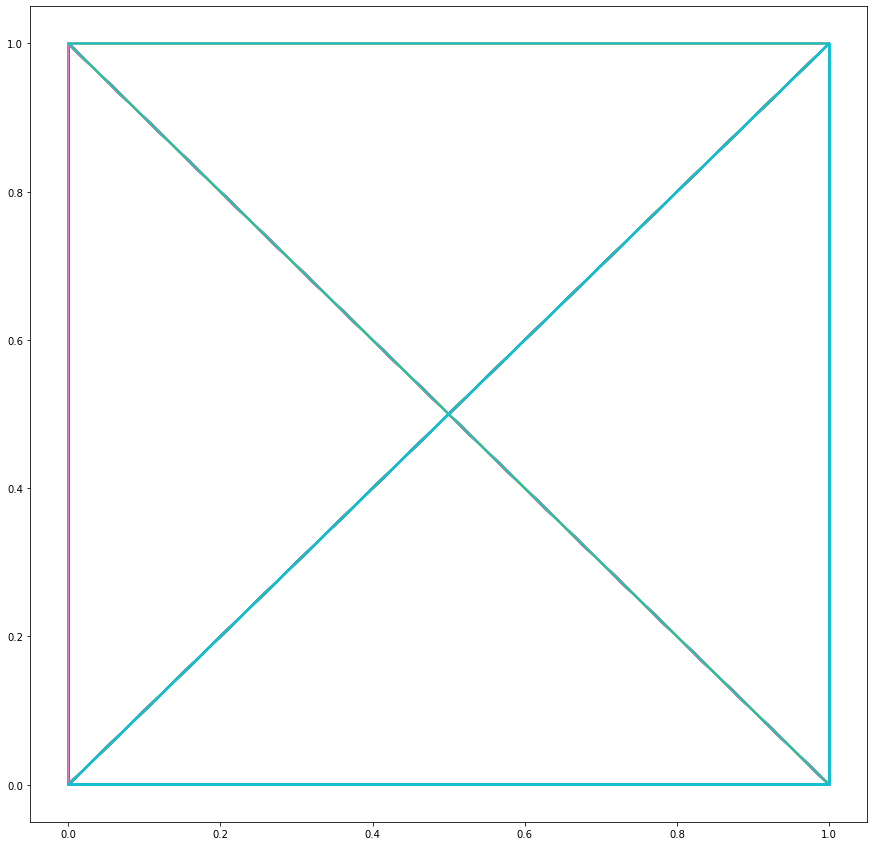

In [140]:
tsvm = test_SVM(EPOCH, BATCH_SIZE, 5)

tsvm.train(
    output_gb_cp,
    db3_label
)

In [ ]:
run_acc = float()
best_acc = float()
print("Test Code GB-DBN Start")
for i, (data) in enumerate(test_dataloader):
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)
        
        sample_data = torch.bernoulli(data).view(-1, 10).to(device=device)

        # tensor binary
        vog_first, v1 = rbm_first(sample_data)
        omse_loss = mse_loss(vog_first, v1)

        first_train_op.zero_grad()
        first_train_op.step()
        omse_loss.backward()

for i, (data) in enumerate(v1):
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)
        
        sample_data = torch.bernoulli(data).view(-1, 10).to(device=device)

        # tensor binary
        vog_second, v2 = rbm_first(sample_data)
        omse_loss = mse_loss(vog_second, v2)

        second_train_op.zero_grad()
        second_train_op.step()
        omse_loss.backward()

for i, (data) in enumerate(v2):
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)
        
        sample_data = torch.bernoulli(data).view(-1, 10).to(device=device)

        # tensor binary
        vog_second, v3 = rbm_first(sample_data)
        omse_loss = mse_loss(vog_second, v3)

        second_train_op.zero_grad()
        second_train_op.step()
        omse_loss.backward()
        run_acc += (sample_data == v3).sum().item()
 
for _, (data) in enumerate(v3): 
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)

        sample_data = torch.normal(mean=data, std=gaussian_std).view(-1, 10).to(device=device)

        # tensor binary
        vog_second, v1 = rbm_first(sample_data)
        omse_loss = mse_loss(vog_second, v1)

        second_train_op.zero_grad()
        omse_loss.backward()
        second_train_op.step()

for _, (data) in enumerate(v1): 
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)

        sample_data = torch.normal(mean=data, std=gaussian_std).view(-1, 10).to(device=device)

        # tensor binary
        vog_second, v2 = rbm_second(sample_data)
        omse_loss = mse_loss(vog_second, v2)

        second_train_op.zero_grad()
        omse_loss.backward()
        second_train_op.step()
        
for _, (data) in enumerate(v2): 
        data = Variable(
                torch.tensor(data, dtype=torch.float32)
        ).uniform_(0, 1)

        sample_data = torch.normal(mean=data, std=gaussian_std).view(-1, 10).to(device=device)

        # tensor binary
        vog_second, v3 = rbm_third(sample_data)
        omse_loss = mse_loss(vog_second, v3)

        second_train_op.zero_grad()
        omse_loss.backward()
        second_train_op.step()
        
acc = get_acc(vog_third, v3)
if acc > best_acc:
    best_acc = acc

path = "./saveMode_through_GBRBM.pth"
torch.save(rbm_third.state_dict(), path)

output_gb.append(v3)
print("GB-DBN Training loss for {0}th epoch {1}\tEstimate time : {2}\tAcc : {3}\tBest Acc : {4}" \
    .format(epoch + 1, omse_loss, time.time() - start, acc, best_acc))

In [ ]:
run_acc = float()


In [ ]:
svm_model_cp = torch.load("svm_model.pth")

In [ ]:
svm_model = SVM(epoch=EPOCH, n_feat=v3.size()[0], n_out=5, batch=BATCH_SIZE, lr=LEARNING_RATE)
svm_optim = optim.Adagrad(svm_model.parameters(), lr=LEARNING_RATE)

svm_model.load_state_dict(svm_model_cp['model_state_dict'])
svm_optim.load_state_dict(svm_model_cp['optimizer_state_dict'])
epoch = svm_model_cp['epoch']
loss = svm_model_cp['loss']

svm_model.eval()